# **Logistic Regression**

In this Jupyter Notebook, we introduce logistic regression using data from the 2017-18 NBA season. We'll perform data cleaning and exploratory data analysis (EDA), and then use logistic regression to model the probability of a team winning a game based on the field goal percentage difference between them and their opponent. We'll compare different loss functions, explore the logistic function, and use scikit-learn to fit the model.

***

## **1. Import Libraries**

First, let's import the necessary libraries.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression

Set plotting parameters.

In [2]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

***

## **2. Motivating Logistic Regression**

In this section, we will load the NBA dataset and perform data cleaning to prepare it for logistic regression.

### **2.1 ~ Loading the Data**

We will use data from the 2017-18 NBA season.

In [3]:
df = pd.read_csv('../data/nba.csv')
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22017,1610612744,GSW,Golden State Warriors,21700002,2017-10-17,GSW vs. HOU,L,240,43,...,35,41,34,5,9,17,25,121,-1,1
1,22017,1610612745,HOU,Houston Rockets,21700002,2017-10-17,HOU @ GSW,W,240,47,...,33,43,28,9,5,13,16,122,1,1
2,22017,1610612738,BOS,Boston Celtics,21700001,2017-10-17,BOS @ CLE,L,240,36,...,37,46,24,11,4,12,24,99,-3,1
3,22017,1610612739,CLE,Cleveland Cavaliers,21700001,2017-10-17,CLE vs. BOS,W,240,38,...,41,50,19,3,4,17,25,102,3,1
4,22017,1610612750,MIN,Minnesota Timberwolves,21700011,2017-10-18,MIN @ SAS,L,240,37,...,31,42,23,7,4,13,16,99,-8,1


### **2.2 ~ Preparing the Target Variable**

We are going to perform **binary classification**, predicting whether a team wins or loses a game. The `WL` column contains `'W'` and `'L'`, representing wins and losses. Let's take a look at the `WL` column.

In [4]:
df['WL'].head()

0    L
1    W
2    L
3    W
4    L
Name: WL, dtype: object

We need to convert `'W'` and `'L'` to numeric values, where `'W'` is `1` and `'L'` is `0`.

In [5]:
df['WON'] = df['WL'].map({'W': 1, 'L': 0})
df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,WON
0,22017,1610612744,GSW,Golden State Warriors,21700002,2017-10-17,GSW vs. HOU,L,240,43,...,41,34,5,9,17,25,121,-1,1,0
1,22017,1610612745,HOU,Houston Rockets,21700002,2017-10-17,HOU @ GSW,W,240,47,...,43,28,9,5,13,16,122,1,1,1
2,22017,1610612738,BOS,Boston Celtics,21700001,2017-10-17,BOS @ CLE,L,240,36,...,46,24,11,4,12,24,99,-3,1,0
3,22017,1610612739,CLE,Cleveland Cavaliers,21700001,2017-10-17,CLE vs. BOS,W,240,38,...,50,19,3,4,17,25,102,3,1,1
4,22017,1610612750,MIN,Minnesota Timberwolves,21700011,2017-10-18,MIN @ SAS,L,240,37,...,42,23,7,4,13,16,99,-8,1,0


### **2.3 ~ Exploring the Feature**

Each row in the dataset represents a team in a game. The `FG_PCT` column represents the team's field goal percentage in that game.

In [6]:
df['FG_PCT'].head()

0    0.538
1    0.485
2    0.409
3    0.458
4    0.435
Name: FG_PCT, dtype: float64

We want to compute the field goal percentage difference between two teams in each game. This will serve as our feature.

### **2.4 ~ Calculating Field Goal Percentage Difference**

First, let's group the data by `GAME_ID` and separate the data for the two teams in each game.

Then, we'll compute the field goal percentage difference.

In [7]:
# Get the first team in each game
one_team = df.groupby("GAME_ID").first()

# Get the second team in each game
opponent = df.groupby("GAME_ID").last()

# Merge the two teams' data for each game
games = one_team.merge(opponent, left_index=True, right_index=True, suffixes=("", "_OPP"))

# Compute the field goal percentage difference
games["FG_PCT_DIFF"] = games["FG_PCT"] - games["FG_PCT_OPP"]

# Update the 'WON' column
games['WON'] = games['WL'].replace({'L': 0, 'W': 1})

# Keep only relevant columns
games = games[['TEAM_NAME', 'MATCHUP', 'WON', 'FG_PCT_DIFF']]

games.head()

/var/folders/zp/_d_rstf11flfs_c9y4mt102w0000gn/T/ipykernel_8060/1265372814.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  games['WON'] = games['WL'].replace({'L': 0, 'W': 1})


,TEAM_NAME,MATCHUP,WON,FG_PCT_DIFF
GAME_ID,,,,
21700001,Boston Celtics,BOS @ CLE,0,-0.049
21700002,Golden State Warriors,GSW vs. HOU,0,0.053
21700003,Charlotte Hornets,CHA @ DET,0,-0.030
21700004,Indiana Pacers,IND vs. BKN,1,0.041
21700005,Orlando Magic,ORL vs. MIA,1,0.042


### **2.5 ~ Visualizing the Data**

Let's create a joint plot of `FG_PCT_DIFF` and `WON` to see the relationship between the field goal percentage difference and the probability of winning.

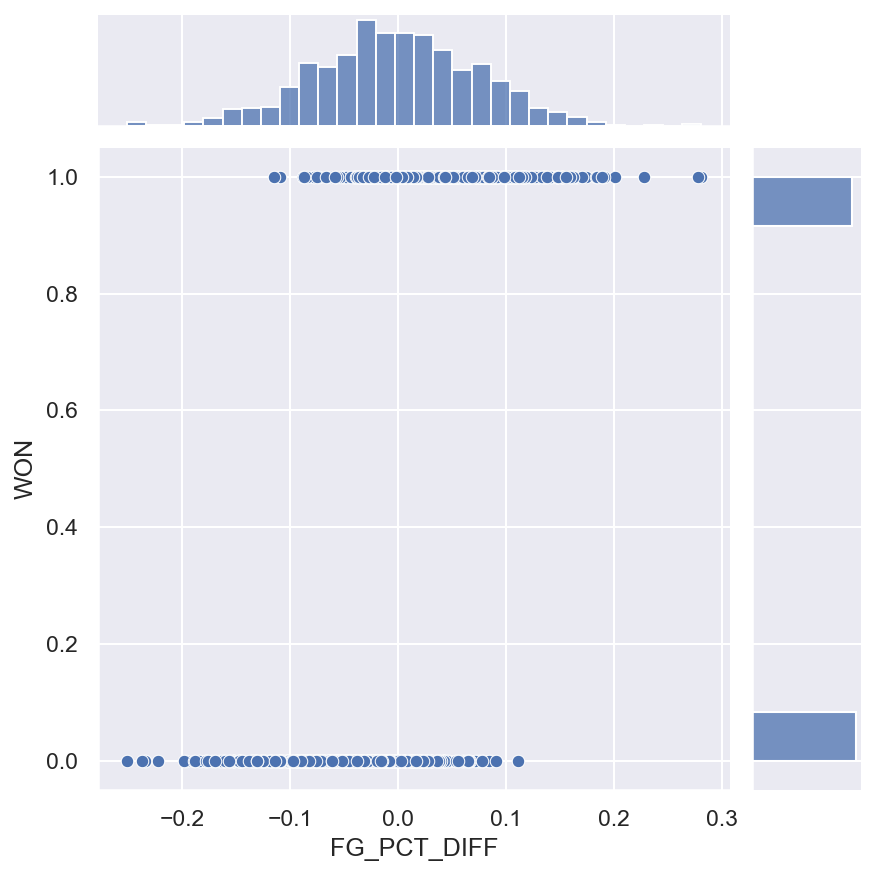

In [8]:
sns.jointplot(data=games, x="FG_PCT_DIFF", y="WON");

Since `WON` is a binary variable (0 or 1), we'll add some jitter to the `y` values to better visualize the data points.

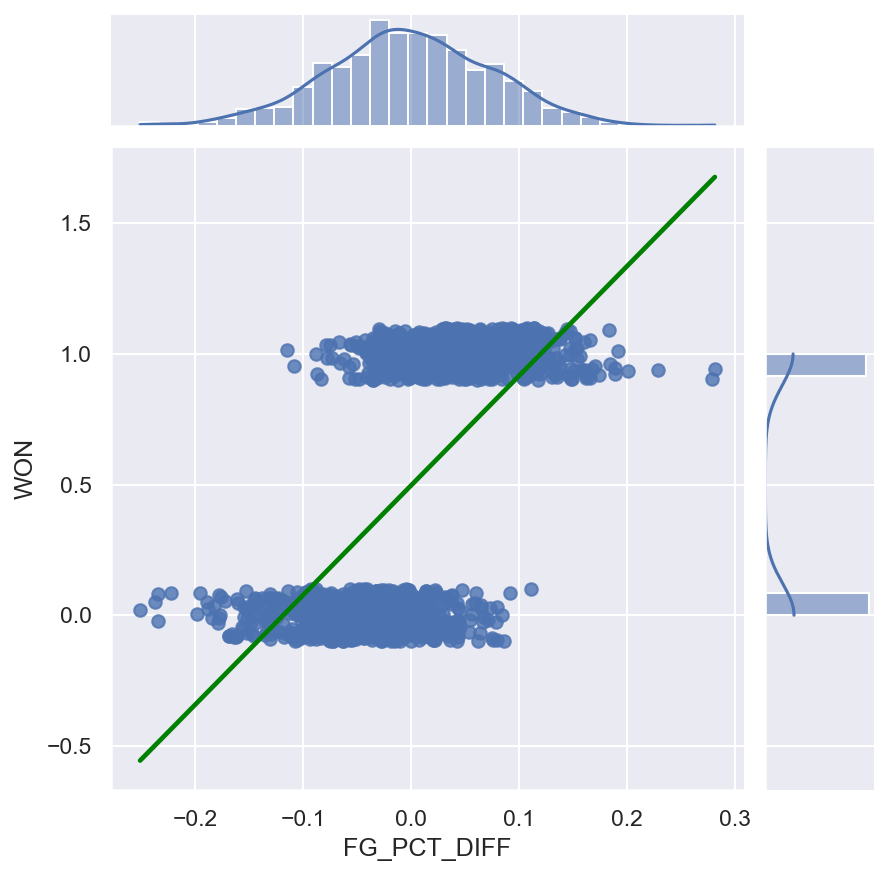

In [9]:
sns.jointplot(data=games, x="FG_PCT_DIFF", y="WON", 
              y_jitter=0.1, 
              kind="reg", 
              ci=False,
              joint_kws={'line_kws':{'color':'green'}});

### **2.6 ~ Limitations of Linear Regression**

The green regression line is the best fit line minimizing the mean squared error (MSE) between the predicted and actual values. However, there are some issues:

- The predicted outputs can be less than 0 or greater than 1, which doesn't make sense for probabilities.
- Linear regression is susceptible to outliers.

Let's demonstrate the impact of an outlier.

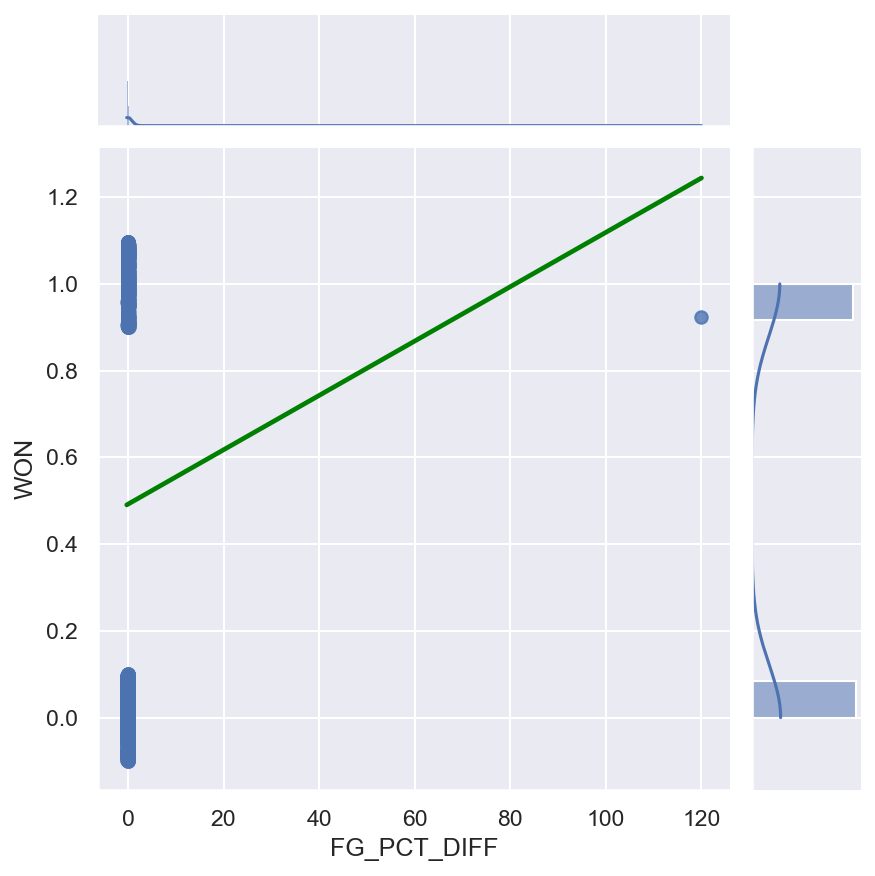

In [10]:
# Create a copy of the games data
games2 = games.copy()

# Introduce an outlier in FG_PCT_DIFF
games2.iloc[0] = ['Outlier Team', 'Outlier vs Opponent', 1, 120]

# Plot the data with the outlier
sns.jointplot(data=games2, x="FG_PCT_DIFF", y="WON", 
              y_jitter=0.1, 
              kind="reg", 
              ci=False,
              joint_kws={'line_kws':{'color':'green'}});

As we can see, the regression line is heavily influenced by the outlier, highlighting the susceptibility of linear regression to outliers.

***

## **3. The Graph of Averages**

A better approach is to model the **probability of winning** given the field goal % difference. We can visualize this using a graph of averages.

### **3.1 ~ Creating Bins and Calculating Win Rates**

We will bin the `FG_PCT_DIFF` values and calculate the average `WON` value (i.e., win rate) in each bin.

In [11]:
# Create bins for FG_PCT_DIFF
bins = pd.cut(games["FG_PCT_DIFF"], 20)
games["bin"] = [(b.left + b.right) / 2 for b in bins]

# Calculate win rates in each bin
win_rates_by_bin = games.groupby("bin")["WON"].mean()
win_rates_by_bin

bin
-0.2380    0.000000
-0.2110    0.000000
-0.1845    0.000000
-0.1580    0.000000
-0.1315    0.000000
-0.1047    0.033898
-0.0781    0.083333
-0.0515    0.148438
-0.0249    0.363636
 0.0017    0.505747
 0.0283    0.705128
 0.0549    0.792793
 0.0815    0.907407
 0.1079    0.984615
 0.1345    1.000000
 0.1615    1.000000
 0.1880    1.000000
 0.2410    1.000000
 0.2675    1.000000
Name: WON, dtype: float64

### **3.2 ~ Plotting the Graph of Averages**

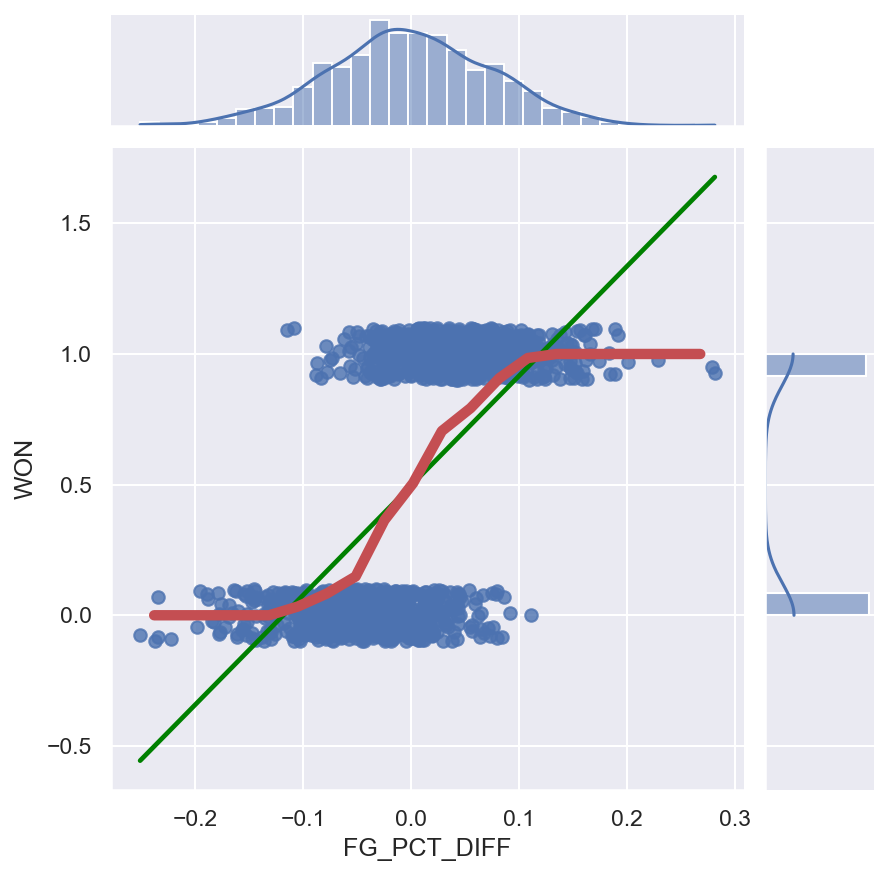

In [12]:
# Create the jointplot
g = sns.jointplot(data=games, x="FG_PCT_DIFF", y="WON", 
                  y_jitter=0.1, 
                  kind="reg", 
                  ci=False,
                  joint_kws={'line_kws':{'color':'green'}})

# Plot the graph of averages on the jointplot's axes
g.ax_joint.plot(win_rates_by_bin.index, win_rates_by_bin.values, 'r', linewidth=5)

# Adjust labels
g.set_axis_labels('FG_PCT_DIFF', 'WON');

The red line (graph of averages) does a better job at matching the data than the simple linear regression line.

***

## **4. The Logistic Function**

To model probabilities, we use the logistic function, which maps any real-valued number into the (0, 1) interval.

### **4.1 ~ Definition of the Logistic Function**

$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

Let's define this function in code.

In [13]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

### **4.2 ~ Visualizing the Logistic Function**

First, we'll plot the logistic function over a range of values.

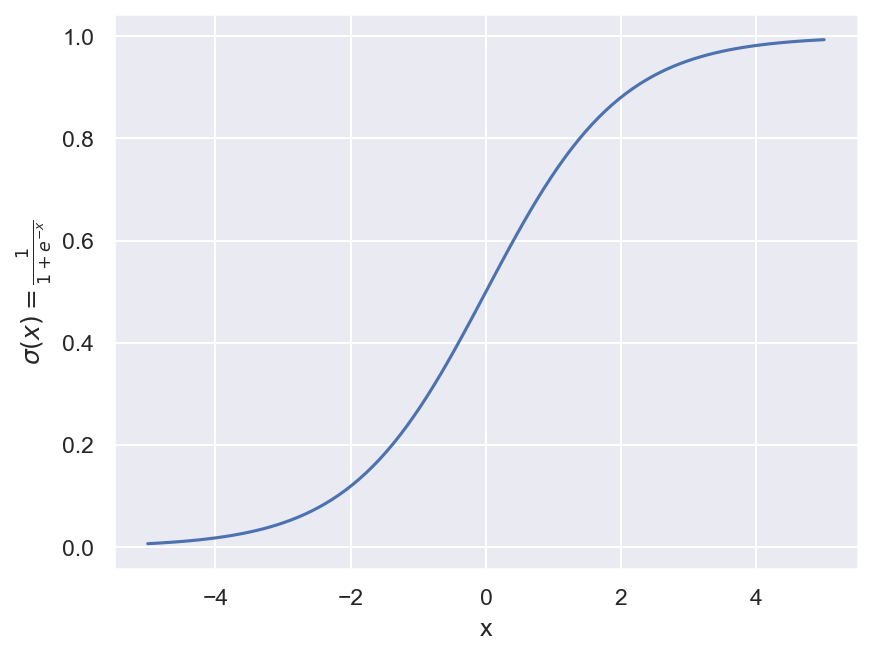

In [14]:
x = np.linspace(-5, 5, 100)
plt.plot(x, sigma(x))
plt.xlabel('x')
plt.ylabel(r'$\sigma(x) = \frac{1}{1 + e^{-x}}$');

### **4.3 ~ Effect of Parameters on the Logistic Function**

Let's explore how changing the parameter $\theta_1$ in $\sigma(\theta_1 x)$ affects the shape of the logistic function.

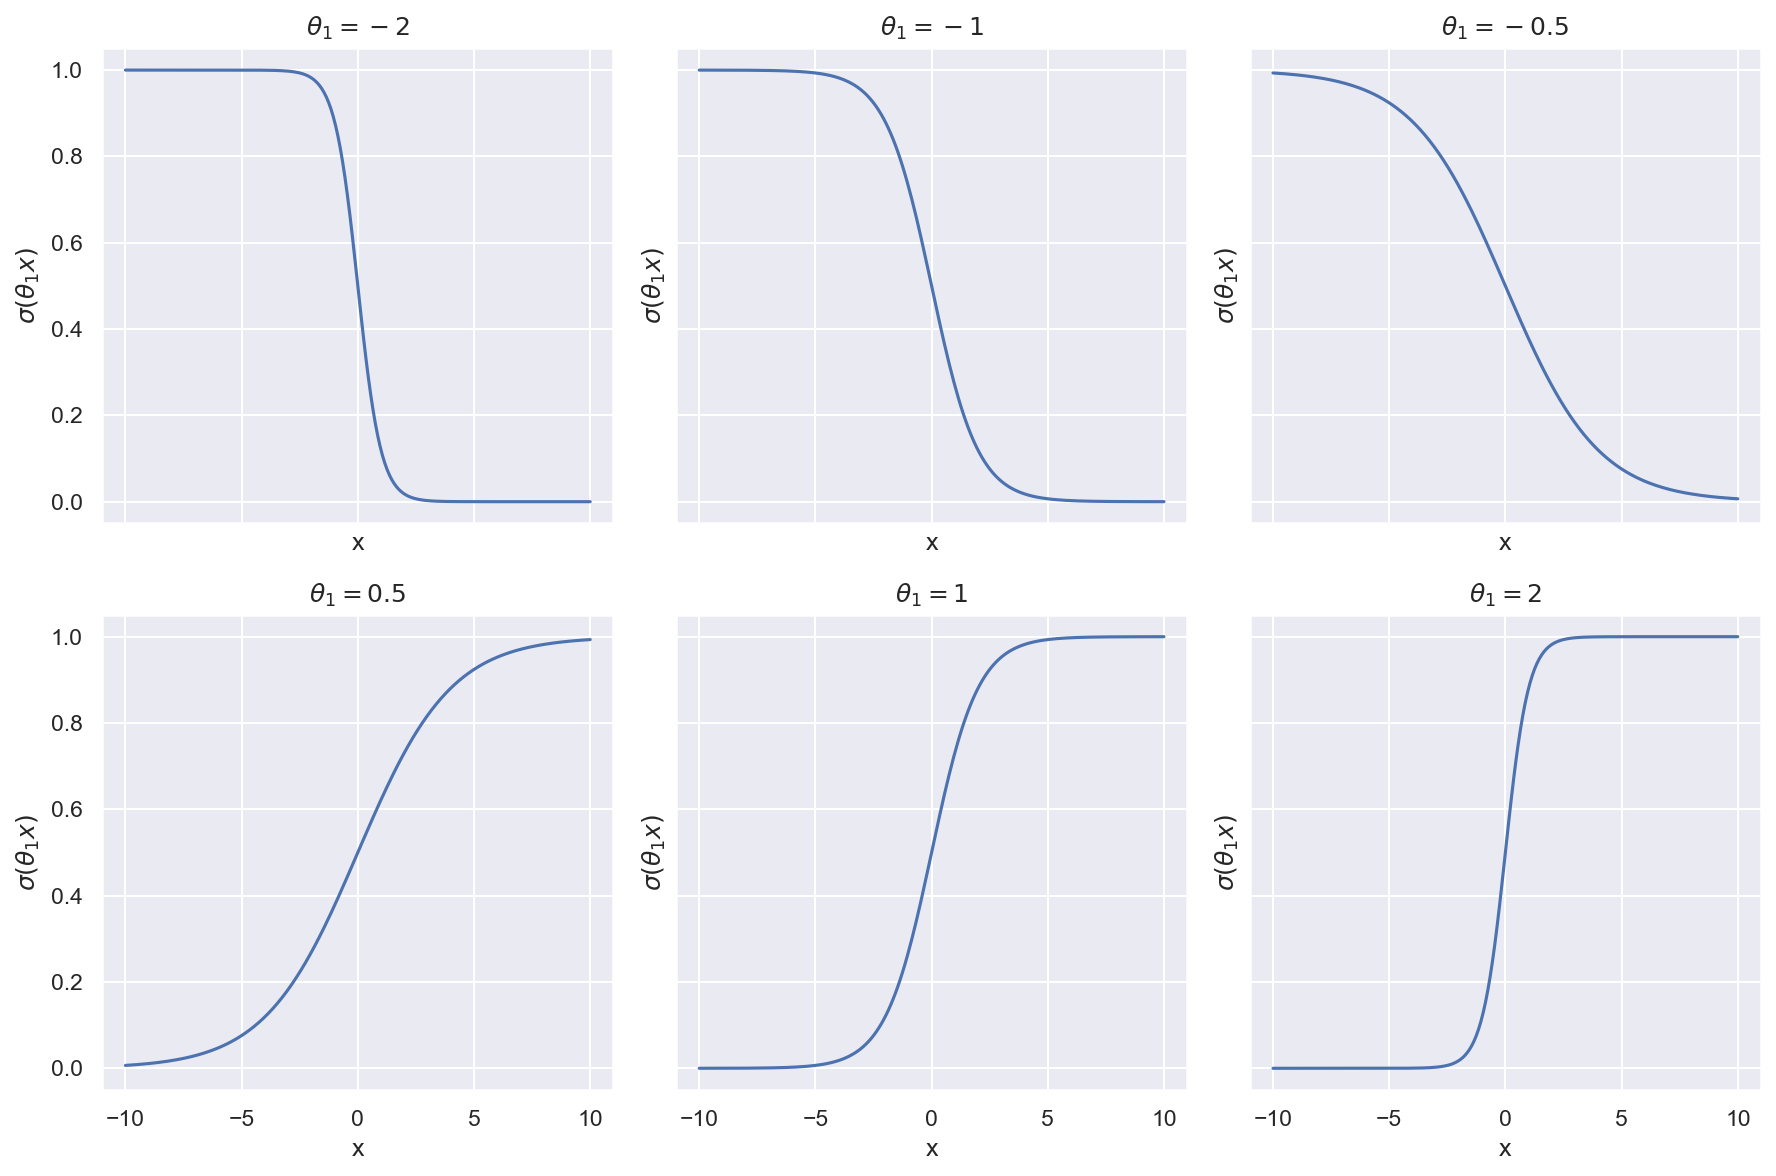

In [15]:
theta1_values = [-2, -1, -0.5, 0.5, 1, 2]
x = np.linspace(-10, 10, 200)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.flatten()

for ax, theta1 in zip(axes, theta1_values):
    y = sigma(theta1 * x)
    ax.plot(x, y)
    ax.set_title(r'$\theta_1 = {}$'.format(theta1))
    ax.set_xlabel('x')
    ax.set_ylabel(r'$\sigma(\theta_1 x)$')

plt.tight_layout()
plt.show()

We can see that the parameter $\theta_1$ controls the steepness of the curve.

### **4.4 ~ Exploring the Logistic Function with Different Parameters**

Now, let's explore the logistic function with both $\theta_0$ and $\theta_1$ in $\sigma(\theta_0 + \theta_1 x)$ using Plotly for interactive visualization.

In [16]:
theta1_values = [-1, 1, 5]
theta0_values = [-2, 0, 2]
x = np.linspace(-10, 10, 200)

fig = go.Figure()

for theta1 in theta1_values:
    for theta0 in theta0_values:
        y = sigma(theta0 + theta1 * x)
        fig.add_trace(go.Scatter(
            x=x, y=y, mode='lines',
            name=f'θ₀={theta0}, θ₁={theta1}'
        ))

fig.update_layout(
    title='Logistic Function with Different θ₀ and θ₁',
    xaxis_title='x',
    yaxis_title='σ(θ₀ + θ₁ x)',
    legend_title='Parameters'
)

fig.show()

***

## **5. Logistic Regression with Squared Loss**

Although we now have a logistic function to model probabilities, we need to choose an appropriate loss function in order to properly optimize the model parameters.

### **5.1 ~ Using Mean Squared Error (MSE)**

First, let's try using the mean squared error (MSE) as the loss function.

In [17]:
def mse_loss_single_arg_nba(theta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(x * theta)
    return np.mean((y_hat - y_obs) ** 2)

### **5.2 ~ Visualizing the Loss Surface**

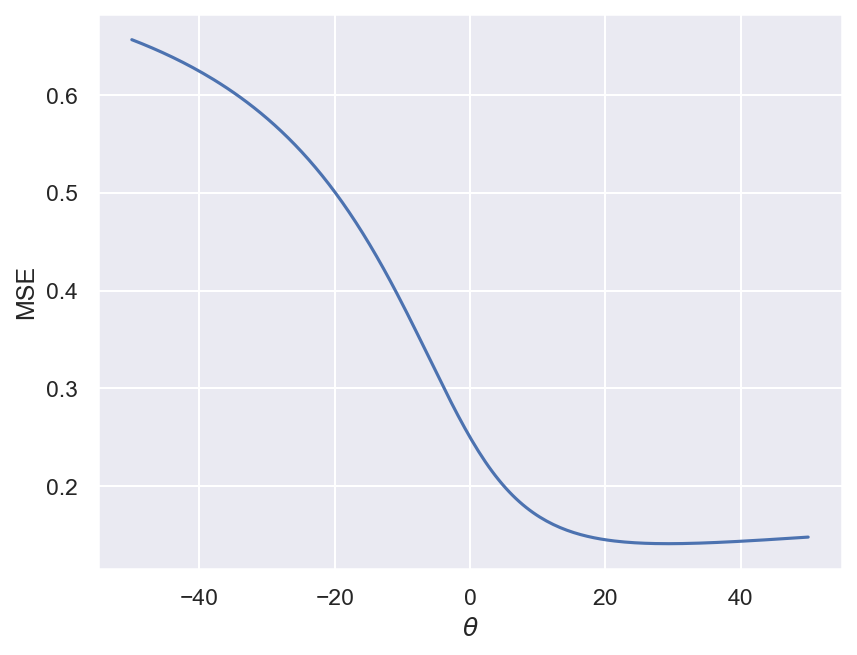

In [18]:
thetas = np.linspace(-50, 50, 200)
mse_losses = [mse_loss_single_arg_nba(theta) for theta in thetas]
plt.plot(thetas, mse_losses)
plt.ylabel('MSE')
plt.xlabel(r'$\theta$');

### **5.3 ~ Finding the Optimal Parameter**

In [19]:
result = minimize(mse_loss_single_arg_nba, x0=0)
optimal_theta_mse = result.x[0]
print(f"Optimal θ using MSE: {optimal_theta_mse}")

Optimal θ using MSE: 29.130078012616185


### **5.4 ~ Plotting the Model Fit**

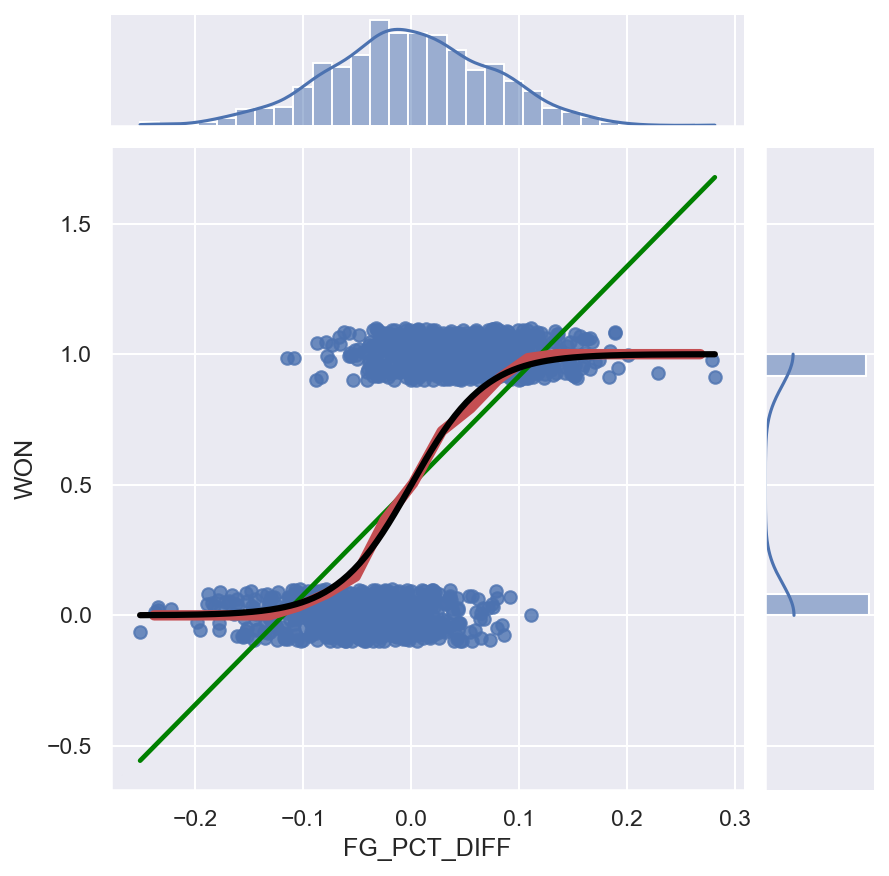

In [20]:
# Create the jointplot
g = sns.jointplot(data=games, x="FG_PCT_DIFF", y="WON", 
                  y_jitter=0.1, 
                  kind="reg", 
                  ci=False,
                  joint_kws={'line_kws':{'color':'green'}})

# Plot the graph of averages on the jointplot's axes
g.ax_joint.plot(win_rates_by_bin.index, win_rates_by_bin.values, 'r', linewidth=5)

# Plot the logistic function with optimal theta
x_vals = np.linspace(min(games["FG_PCT_DIFF"]), max(games["FG_PCT_DIFF"]), 200)
y_vals = sigma(optimal_theta_mse * x_vals)
g.ax_joint.plot(x_vals, y_vals, 'black', linewidth=3)

# Adjust labels
g.set_axis_labels('FG_PCT_DIFF', 'WON');

### **5.5 ~ Limitations of Squared Loss**

While squared loss worked reasonably well in this case, it may not always be appropriate.

Let's consider a manufactured example to illustrate this.

#### *Manufactured Example*

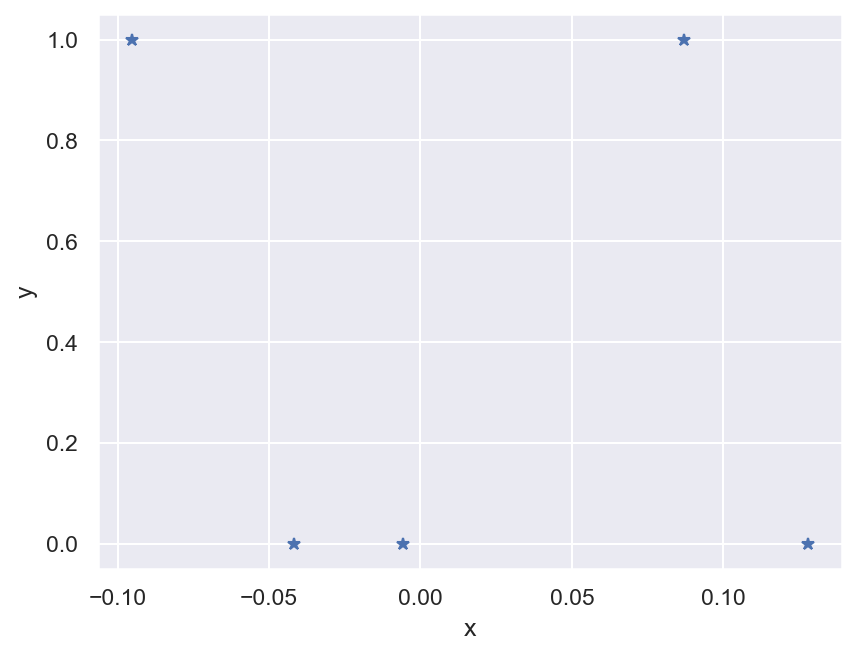

In [21]:
rand_x = np.array([[-0.04185564],
                   [ 0.12799961],
                   [-0.09528101],
                   [-0.0058139 ],
                   [ 0.0870956 ]])
rand_y = np.array([[0],
                   [0],
                   [1],
                   [0],
                   [1]])

plt.plot(rand_x, rand_y, 'b*')
plt.xlabel('x')
plt.ylabel('y');

### **5.6 ~ Defining the MSE Loss Function**

In [22]:
def mse_loss_single_arg_toy(theta):
    x = rand_x.flatten()
    y_obs = rand_y.flatten()
    y_hat = sigma(x * theta)
    return np.mean((y_obs - y_hat)**2)

### **5.7 ~ Visualizing the Loss Surface**

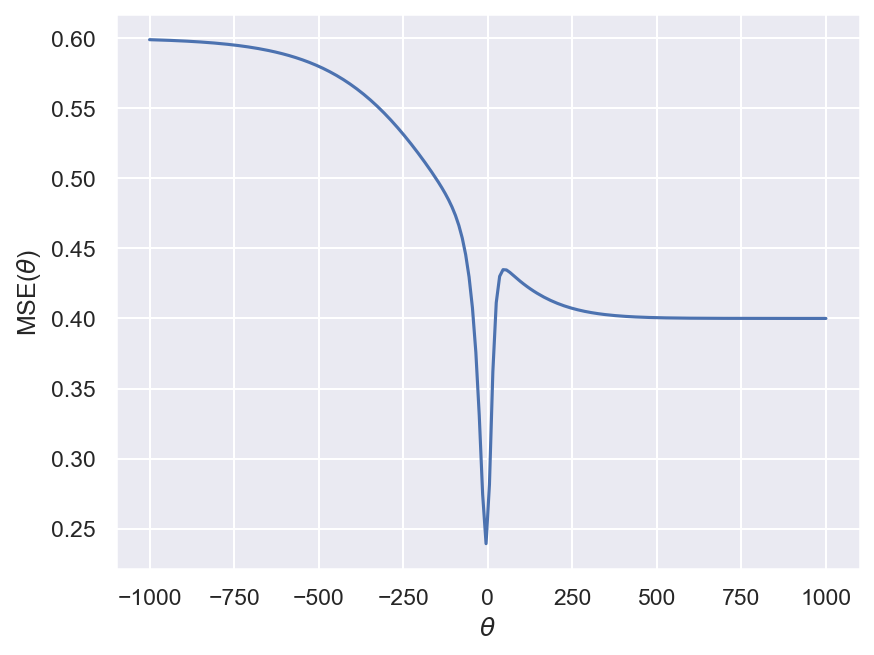

In [23]:
thetas = np.linspace(-1000, 1000, 200)
mse_losses_toy = [mse_loss_single_arg_toy(theta) for theta in thetas]
plt.plot(thetas, mse_losses_toy)
plt.ylabel(r'MSE($\theta$)')
plt.xlabel(r'$\theta$');

As we can see, the loss surface is not convex, which can lead to issues with optimization.

### **5.8 ~ Finding the Optimal Parameter with Different Starting Points**

First, starting at 0.

<>:11: SyntaxWarning:

invalid escape sequence '\h'

<>:11: SyntaxWarning:

invalid escape sequence '\h'

/var/folders/zp/_d_rstf11flfs_c9y4mt102w0000gn/T/ipykernel_8060/218085159.py:11: SyntaxWarning:

invalid escape sequence '\h'



Optimal θ starting at 0: -4.801981341432673


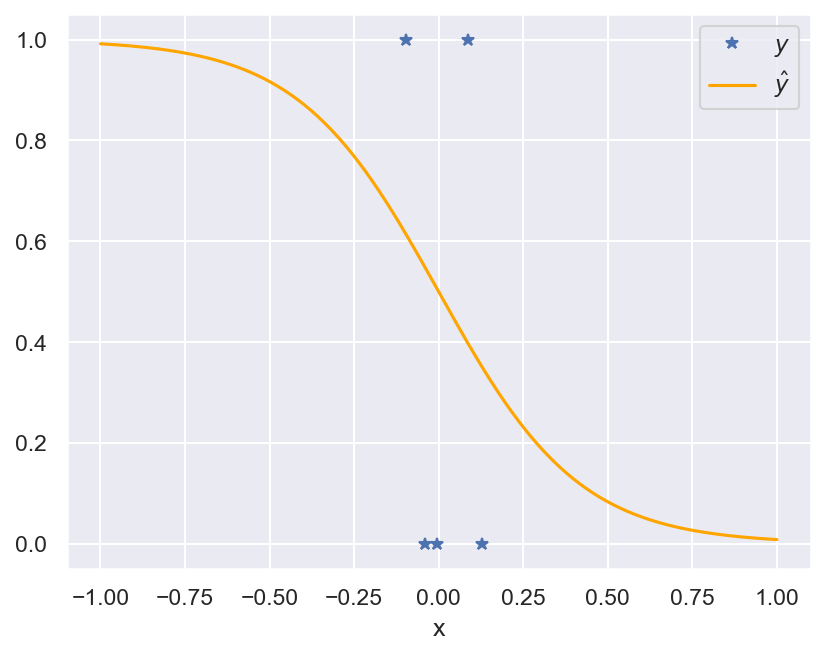

In [24]:
result_toy = minimize(mse_loss_single_arg_toy, x0=0)
best_theta_toy = result_toy.x[0]
print(f"Optimal θ starting at 0: {best_theta_toy}")

# Plotting the model
plt.plot(rand_x, rand_y, 'b*')
x_vals = np.linspace(-1, 1, 200)
y_vals = sigma(best_theta_toy * x_vals)
plt.plot(x_vals, y_vals, color='orange')
plt.xlabel('x')
plt.legend(['$y$', '$\hat{y}$']);

Now, starting at 500.

Optimal θ starting at 500: 500.0


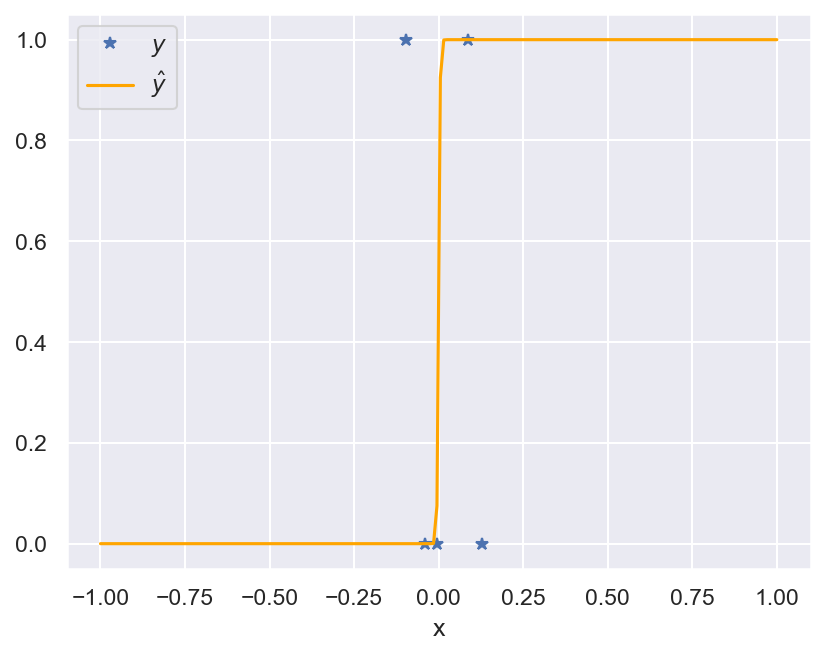

In [25]:
result_toy_500 = minimize(mse_loss_single_arg_toy, x0=500)
best_theta_toy_500 = result_toy_500.x[0]
print(f"Optimal θ starting at 500: {best_theta_toy_500}")

# Plotting the model
plt.plot(rand_x, rand_y, 'b*')
x_vals = np.linspace(-1, 1, 200)
y_vals = sigma(best_theta_toy_500 * x_vals)
plt.plot(x_vals, y_vals, color='orange')
plt.xlabel('x')
plt.legend([r'$y$', r'$\hat{y}$']);

As we can see, the optimization may converge to different local minima depending on the starting point due to the non-convexity of the loss surface.

---

## **6. Cross-Entropy Loss**

To address the issues with MSE, we can use the cross-entropy loss function, which is more suitable for classification problems.

### **6.1 ~ Defining Cross-Entropy Loss**

For a single observation:

$$
\text{loss} = -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})
$$

In code:

In [26]:
def cross_entropy(y, yhat):
    epsilon = 1e-15  # To avoid log(0)
    yhat = np.clip(yhat, epsilon, 1 - epsilon)
    return - y * np.log(yhat) - (1 - y) * np.log(1 - yhat)

### **6.2 ~ Defining the Loss Function for the Toy Dataset**

In [27]:
def mce_loss_single_arg_toy(theta):
    x = rand_x.flatten()
    y_obs = rand_y.flatten()
    y_hat = sigma(x * theta)
    return np.mean(cross_entropy(y_obs, y_hat))

### **6.3 ~ Visualizing the Cross-Entropy Loss Surface**

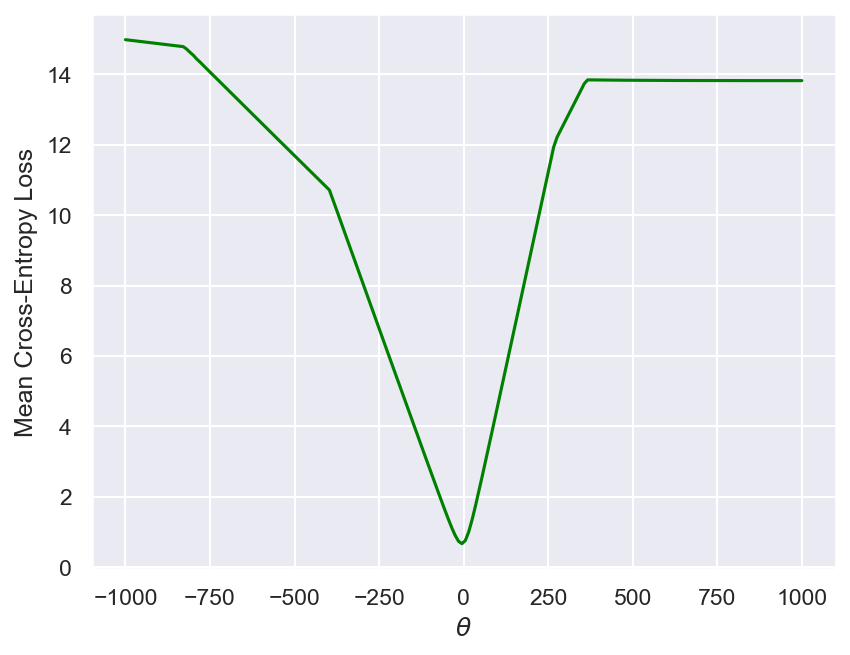

In [28]:
thetas = np.linspace(-1000, 1000, 200)
ce_losses_toy = [mce_loss_single_arg_toy(theta) for theta in thetas]
plt.plot(thetas, ce_losses_toy, color='green')
plt.ylabel(r'Mean Cross-Entropy Loss')
plt.xlabel(r'$\theta$');

Now the loss surface is convex, which is better for optimization.

### **6.4 ~ Finding the Optimal Parameter**

Optimal θ using Cross-Entropy: -5.213601516313596


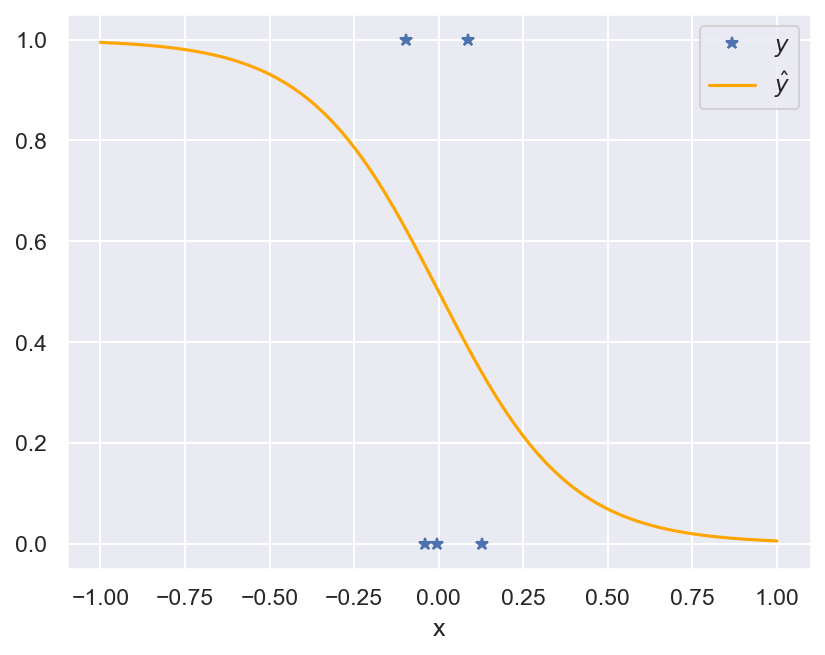

In [29]:
result_ce_toy = minimize(mce_loss_single_arg_toy, x0=0)
best_theta_ce_toy = result_ce_toy.x[0]
print(f"Optimal θ using Cross-Entropy: {best_theta_ce_toy}")

# Plotting the model
plt.plot(rand_x, rand_y, 'b*')
x_vals = np.linspace(-1, 1, 200)
y_vals = sigma(best_theta_ce_toy * x_vals)
plt.plot(x_vals, y_vals, color='orange')
plt.xlabel('x')
plt.legend([r'$y$', r'$\hat{y}$']);

### **6.5 ~ Applying Cross-Entropy Loss to the NBA Dataset**

In [30]:
def mce_loss_single_arg_nba(theta):
    x = games["FG_PCT_DIFF"]
    y_obs = games["WON"]
    y_hat = sigma(theta * x)
    return np.mean(cross_entropy(y_obs, y_hat))

In [31]:
result_ce_nba = minimize(mce_loss_single_arg_nba, x0=0)
optimal_theta_ce_nba = result_ce_nba.x[0]
print(f"Optimal θ using Cross-Entropy on NBA data: {optimal_theta_ce_nba}")

Optimal θ using Cross-Entropy on NBA data: 30.578808323155144


Comparing with the θ from MSE:

In [32]:
print(f"Optimal θ using MSE on NBA data: {optimal_theta_mse}")

Optimal θ using MSE on NBA data: 29.130078012616185


***

## **7. Predicting Probabilities**

Now that we have the optimal parameter, we can predict probabilities.

### **7.1 ~ Predicting Probabilities Manually**

In [33]:
def predict_probabilities(X, theta):
    return sigma(X * theta)

In [34]:
probabilities = predict_probabilities(games['FG_PCT_DIFF'], optimal_theta_ce_nba)
probabilities.head()

GAME_ID
21700001    0.182670
21700002    0.834888
21700003    0.285495
21700004    0.777945
21700005    0.783183
Name: FG_PCT_DIFF, dtype: float64

### **7.2 ~ Using scikit-learn**

We can use scikit-learn's `LogisticRegression` model to fit the data and predict probabilities.

In [35]:
# Initialize the model without regularization and without intercept
model = LogisticRegression(penalty=None, fit_intercept=False, solver='lbfgs')

# Reshape the feature to be 2D as required by scikit-learn
X = games[['FG_PCT_DIFF']]
y = games['WON']

# Fit the model
model.fit(X, y)

# Retrieve the coefficient
print(f"Optimal θ from scikit-learn: {model.coef_[0][0]}")

# Compare with our manually computed θ
print(f"Optimal θ using Cross-Entropy: {optimal_theta_ce_nba}")

Optimal θ from scikit-learn: 30.53925037831342
Optimal θ using Cross-Entropy: 30.578808323155144


The coefficients are very close.

### **7.3 ~ Predicting Probabilities with scikit-learn**

In [36]:
# Predict probabilities
probs_sklearn = model.predict_proba(X)[:, 1]
probs_sklearn[:5]

array([0.18295959, 0.83459924, 0.28573739, 0.77766477, 0.78290028])

These probabilities should be the same as those we computed manually.

In [37]:
# Compare with manual probabilities
probabilities[:5]

GAME_ID
21700001    0.182670
21700002    0.834888
21700003    0.285495
21700004    0.777945
21700005    0.783183
Name: FG_PCT_DIFF, dtype: float64

### **7.4 ~ Predicting the Outcome**

We can use the `.predict()` method to get the predicted class labels (0 or 1).

In [38]:
predictions = model.predict(X)
predictions[:5]

array([0, 1, 0, 1, 1])

Logistic Regression uses a threshold of 0.5 to convert predicted probabilities into class labels.

**Question**: How does scikit-learn decide whether to classify an observation as 0 or 1?

**Answer**: By default, scikit-learn uses a threshold of `0.5`. If the predicted probability is greater than `0.5`, it predicts `1`; otherwise, it predicts `0`.

### **7.5 ~ Evaluate Model Performance**

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("CONFUSION MATRIX:\n", confusion_matrix(games['WON'], predictions))
print("\nCLASSIFICATION REPORT:\n", classification_report(games['WON'], predictions))

CONFUSION MATRIX:
 [[507 118]
 [133 472]]

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       625
           1       0.80      0.78      0.79       605

    accuracy                           0.80      1230
   macro avg       0.80      0.80      0.80      1230
weighted avg       0.80      0.80      0.80      1230

